In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
from pylab import *
import cv2
from albumentations import Compose, RandomCrop, VerticalFlip, HorizontalFlip, Normalize, CenterCrop, Resize
from albumentations.pytorch.functional import img_to_tensor
rcParams['figure.figsize'] = 10, 10

In [ ]:
from torch import nn
import torch
from torchvision import models
import torchvision
from torch.nn import functional as F

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super(ConvRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)
class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False):

        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [ ]:
model_instruments = UNet16(8)
model_instruments_path="/content/gdrive/MyDrive/unet16/unet16_instruments_20/model_0.pt"
state = torch.load(str(model_instruments_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model_instruments.load_state_dict(state)
model_instruments.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


UNet16(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15)

In [ ]:
model_parts = UNet16(4)
model_parts_path="/content/gdrive/MyDrive/unet16/unet16_parts_20/model_0.pt"
state = torch.load(str(model_parts_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model_parts.load_state_dict(state)
model_parts.eval()

UNet16(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15)

In [ ]:
model_binary = UNet16(1)
model_binary_path="/content/gdrive/MyDrive/unet16/unet16_binary_20/model_0.pt"
state = torch.load(str(model_binary_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model_binary.load_state_dict(state)
model_binary.eval()

UNet16(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15)

In [ ]:
def resized_img(p=1):
    return Compose([
        CenterCrop(height=640,width=960),
        Resize(height=960, width=1280, p=1),
    ], p=p)
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)
def load_image(path):

    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

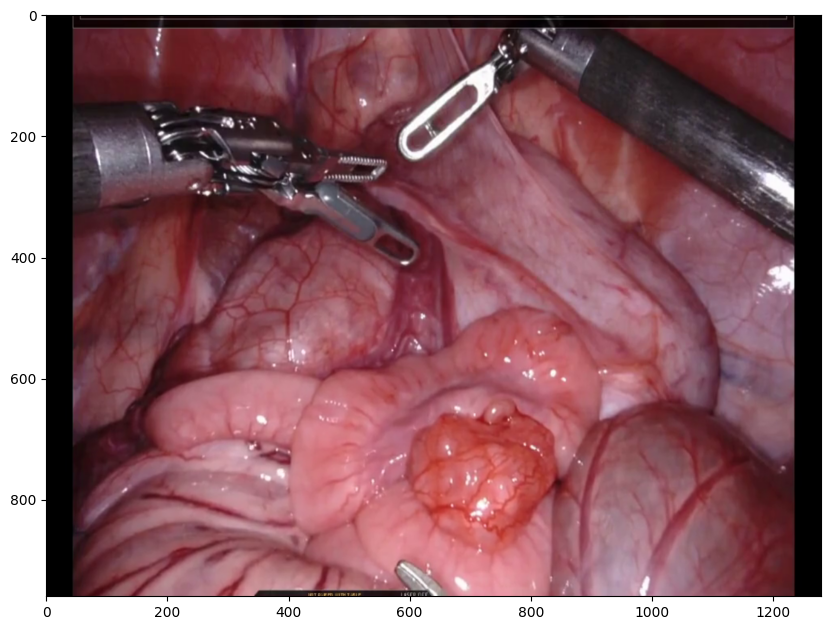

In [ ]:
image_file_name="/content/gdrive/MyDrive/video_to_image/clip_000027/frame_10.png"
image = load_image(image_file_name)

image = resized_img(p=1)(image=image)['image']
imshow(image)



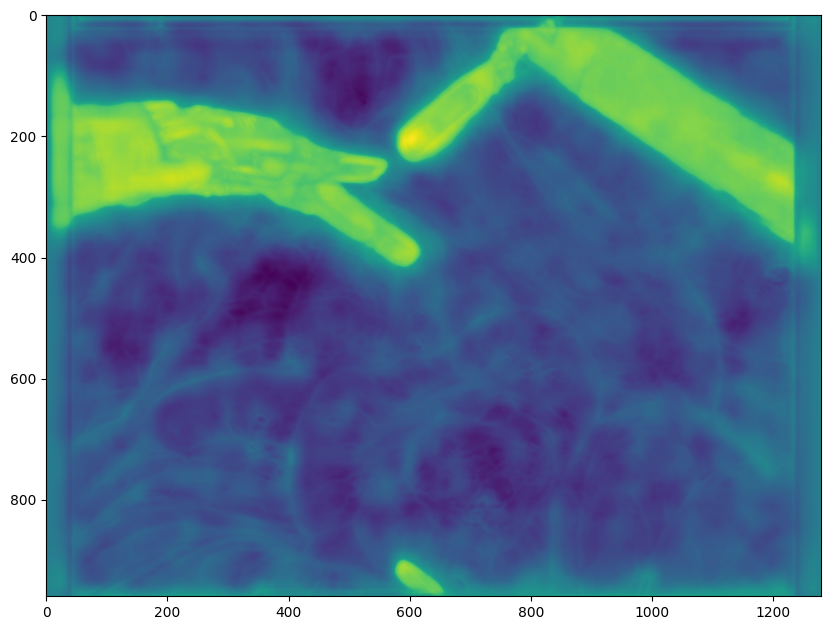

In [ ]:
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)
model_binary = model_binary.cuda()
binary_mask = model_binary(input_image)
binary_mask_array = binary_mask.data[0].cpu().numpy()[0]
binary_mask = binary_mask.squeeze().data.cpu().numpy()
imshow(binary_mask_array)


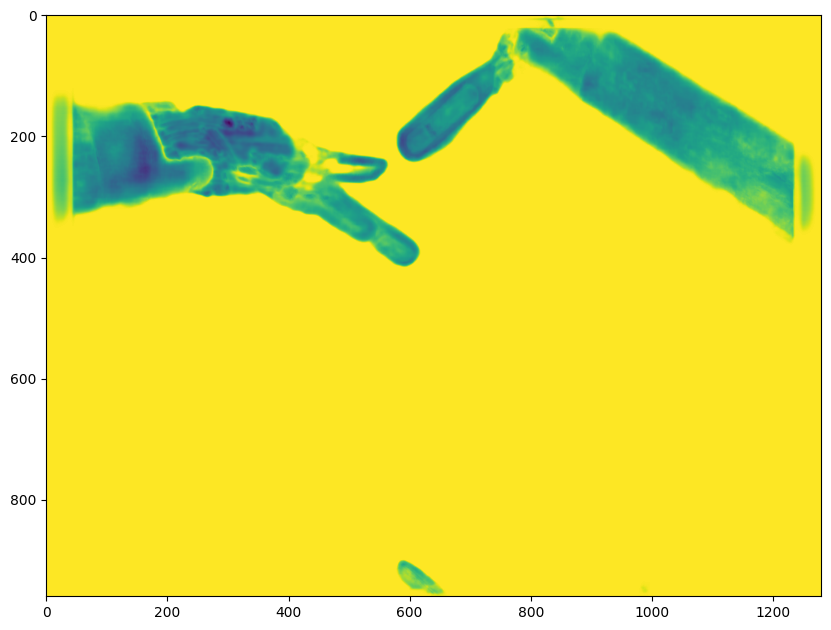

In [ ]:
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)
model_parts = model_parts.cuda()
parts_mask = model_parts(input_image)
parts_mask_array = parts_mask.data[0].cpu().numpy()[0]
parts_mask = parts_mask.squeeze().data.cpu().numpy()
imshow(parts_mask_array)


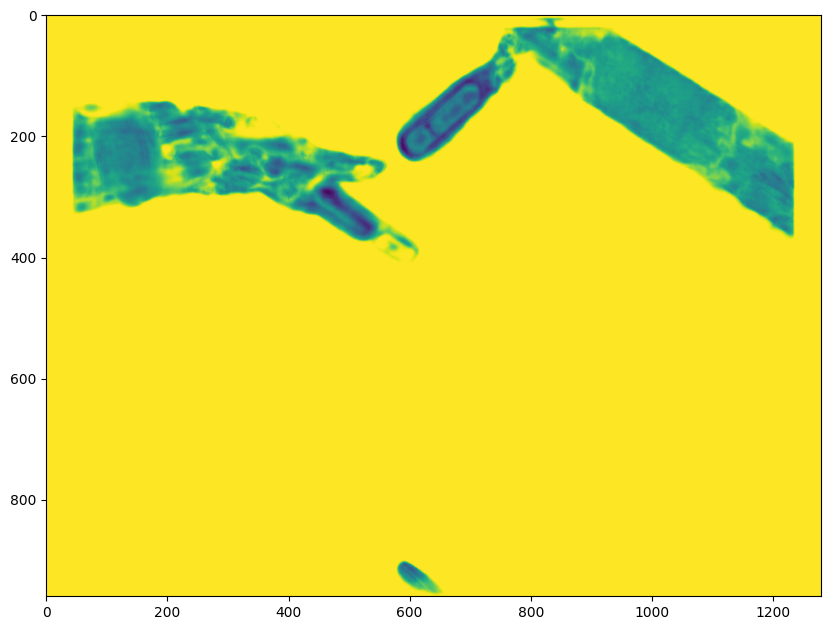

In [ ]:
model_instruments = model_instruments.cuda()
instruments_mask = model_instruments(input_image)
instruments_mask_array = instruments_mask.data[0].cpu().numpy()[0]
instruments_mask = instruments_mask.squeeze().data.cpu().numpy()
imshow(instruments_mask_array)

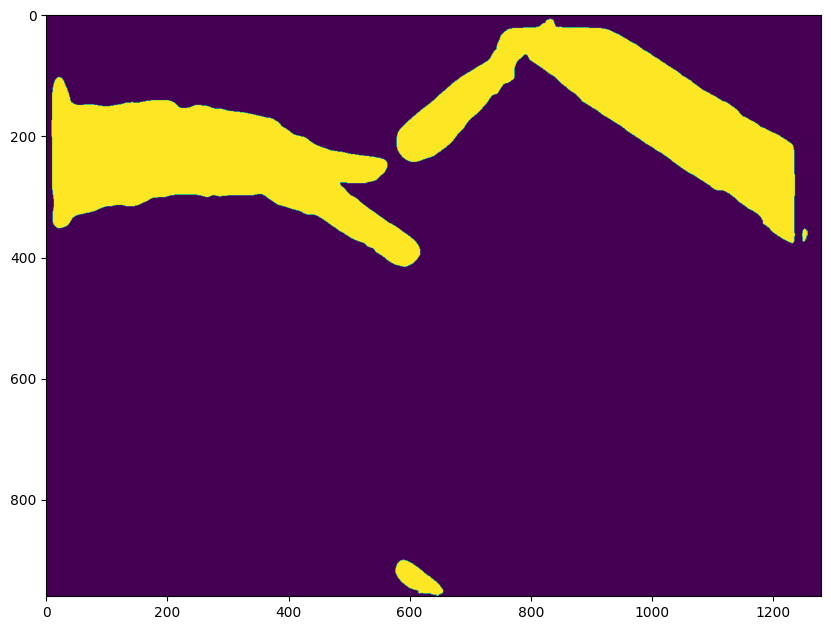

In [ ]:
binary_gray_feature_map=(binary_mask_array > 0).astype(int)
# 显示结果
imshow(binary_gray_feature_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


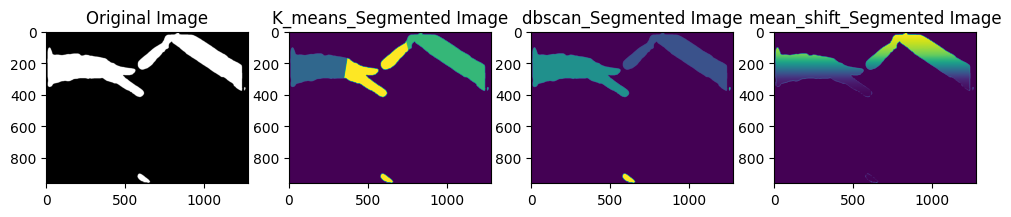

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# 读取灰度图像
tmp_image = binary_gray_feature_map
print(tmp_image)
# 将图像转换为一维数组
non_zero_coords = np.column_stack(np.where(tmp_image != 0))

# 定义聚类数
k = 3

# 使用K均值进行聚类
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(non_zero_coords)
K_means_labels = kmeans.predict(non_zero_coords)

K_means_segmented_image = np.zeros_like(tmp_image)

for i, label in enumerate(K_means_labels):
    x, y = non_zero_coords[i]
    K_means_segmented_image[x, y] = label + 1

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(non_zero_coords)

dbscan_segmented_image = np.zeros_like(tmp_image)
for i, label in enumerate(dbscan_labels):
    x, y = non_zero_coords[i]
    dbscan_segmented_image[x, y] = label + 1

mean_shift_model = MeanShift(bandwidth=1.0)
mean_shift_labels = mean_shift_model.fit_predict(non_zero_coords)
mean_shift_segmented_image = np.zeros_like(tmp_image)
for i, label in enumerate(mean_shift_labels):
    x, y = non_zero_coords[i]
    mean_shift_segmented_image[x, y] = label + 1

# 可视化结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(tmp_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(K_means_segmented_image, cmap='viridis')
plt.title('K_means_Segmented Image')
plt.subplot(1, 4, 3)
plt.imshow(dbscan_segmented_image, cmap='viridis')
plt.title('dbscan_Segmented Image')
plt.subplot(1, 4, 4)
plt.imshow(mean_shift_segmented_image, cmap='viridis')
plt.title('mean_shift_Segmented Image')
plt.show()

**This shows that dbscan_segmentation is preferred.**